In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

In [3]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.6, 0.3])

In [4]:
h_p = -np.sum(p * np.log2(p))
print("Entropia di p: ", h_p)

Entropia di p:  1.4854752972273344


In [5]:
h_pq = -np.sum(p * np.log2(q))
print("Entropia incrociata tra p e q: ", h_pq)

Entropia incrociata tra p e q:  1.5539580943104374


In [6]:
kl_pq = h_pq - h_p
print("Divergenza KL da p a q: ", kl_pq)

Divergenza KL da p a q:  0.06848279708310301


In [7]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


In [8]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


In [9]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


In [10]:
kl_pq1 = np.sum(true_py * np.log(true_py / q1))
print("Divergenza KL da p a q1: ", kl_pq1)

Divergenza KL da p a q1:  0.029251990333459106


In [11]:
kl_pq2 = np.sum(true_py * np.log(true_py / q2))
print("Divergenza KL da p a q2: ", kl_pq2)

Divergenza KL da p a q2:  0.48635777871415453


In [12]:
# Definire le distribuzioni p e q
p = np.array([0.01, 0.99])
q = np.array([0.7, 0.3])

# Calcolo dell'entropia di p
h_p = -np.sum(p * np.log(p))

# Calcolo dell'entropia incrociata da p a q
h_pq = -np.sum(p * np.log(q))

# Calcolo della divergenza KL da p a q
kl_pq = h_pq - h_p

# Calcolo dell'entropia di q
h_q = -np.sum(q * np.log(q))

# Calcolo dell'entropia incrociata da q a p
h_qp = -np.sum(q * np.log(p))

# Calcolo della divergenza KL da q a p
kl_qp = h_qp - h_q

print(f"Entropia di p: {h_p}")
print(f"Entropia incrociata da p a q: {h_pq}")
print(f"Divergenza KL da p a q: {kl_pq}")

print(f"\nEntropia di q: {h_q}")
print(f"Entropia incrociata da q a p: {h_qp}")
print(f"Divergenza KL da q a p: {kl_qp}")

Entropia di p: 0.056001534354847345
Entropia incrociata da p a q: 1.1954998257220641
Divergenza KL da p a q: 1.1394982913672167

Entropia di q: 0.6108643020548935
Entropia incrociata da q a p: 3.226634230947714
Divergenza KL da q a p: 2.6157699288928207


In [13]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]


In [14]:
# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)
print(error)

-0.374907197438445
3.02352587411292e-12


In [15]:
1 / n * np.sum(np.log(p(y_data)))

-0.3721938430299501

In [16]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

In [17]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [18]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:00.703962
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.644237
Transforming variables...
Transformation time =  0:00:00.015314
Computing Log Likelihood...


Log Likelihood time =  0:00:00.216436


In [19]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [20]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:01.068782
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.226091
Transforming variables...
Transformation time =  0:00:00.003267
Computing Log Likelihood...
Log Likelihood time =  0:00:00.051018


In [21]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.41     6.90
p_loo        2.71        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [22]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2253.21   196.01
p_loo       44.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [23]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.412484,2.706173,0.000000,1.000000e+00,6.895383,0.000000,False,log
intercept_model,1,-2253.212385,44.784446,2008.799901,4.028777e-10,196.005519,195.650396,False,log


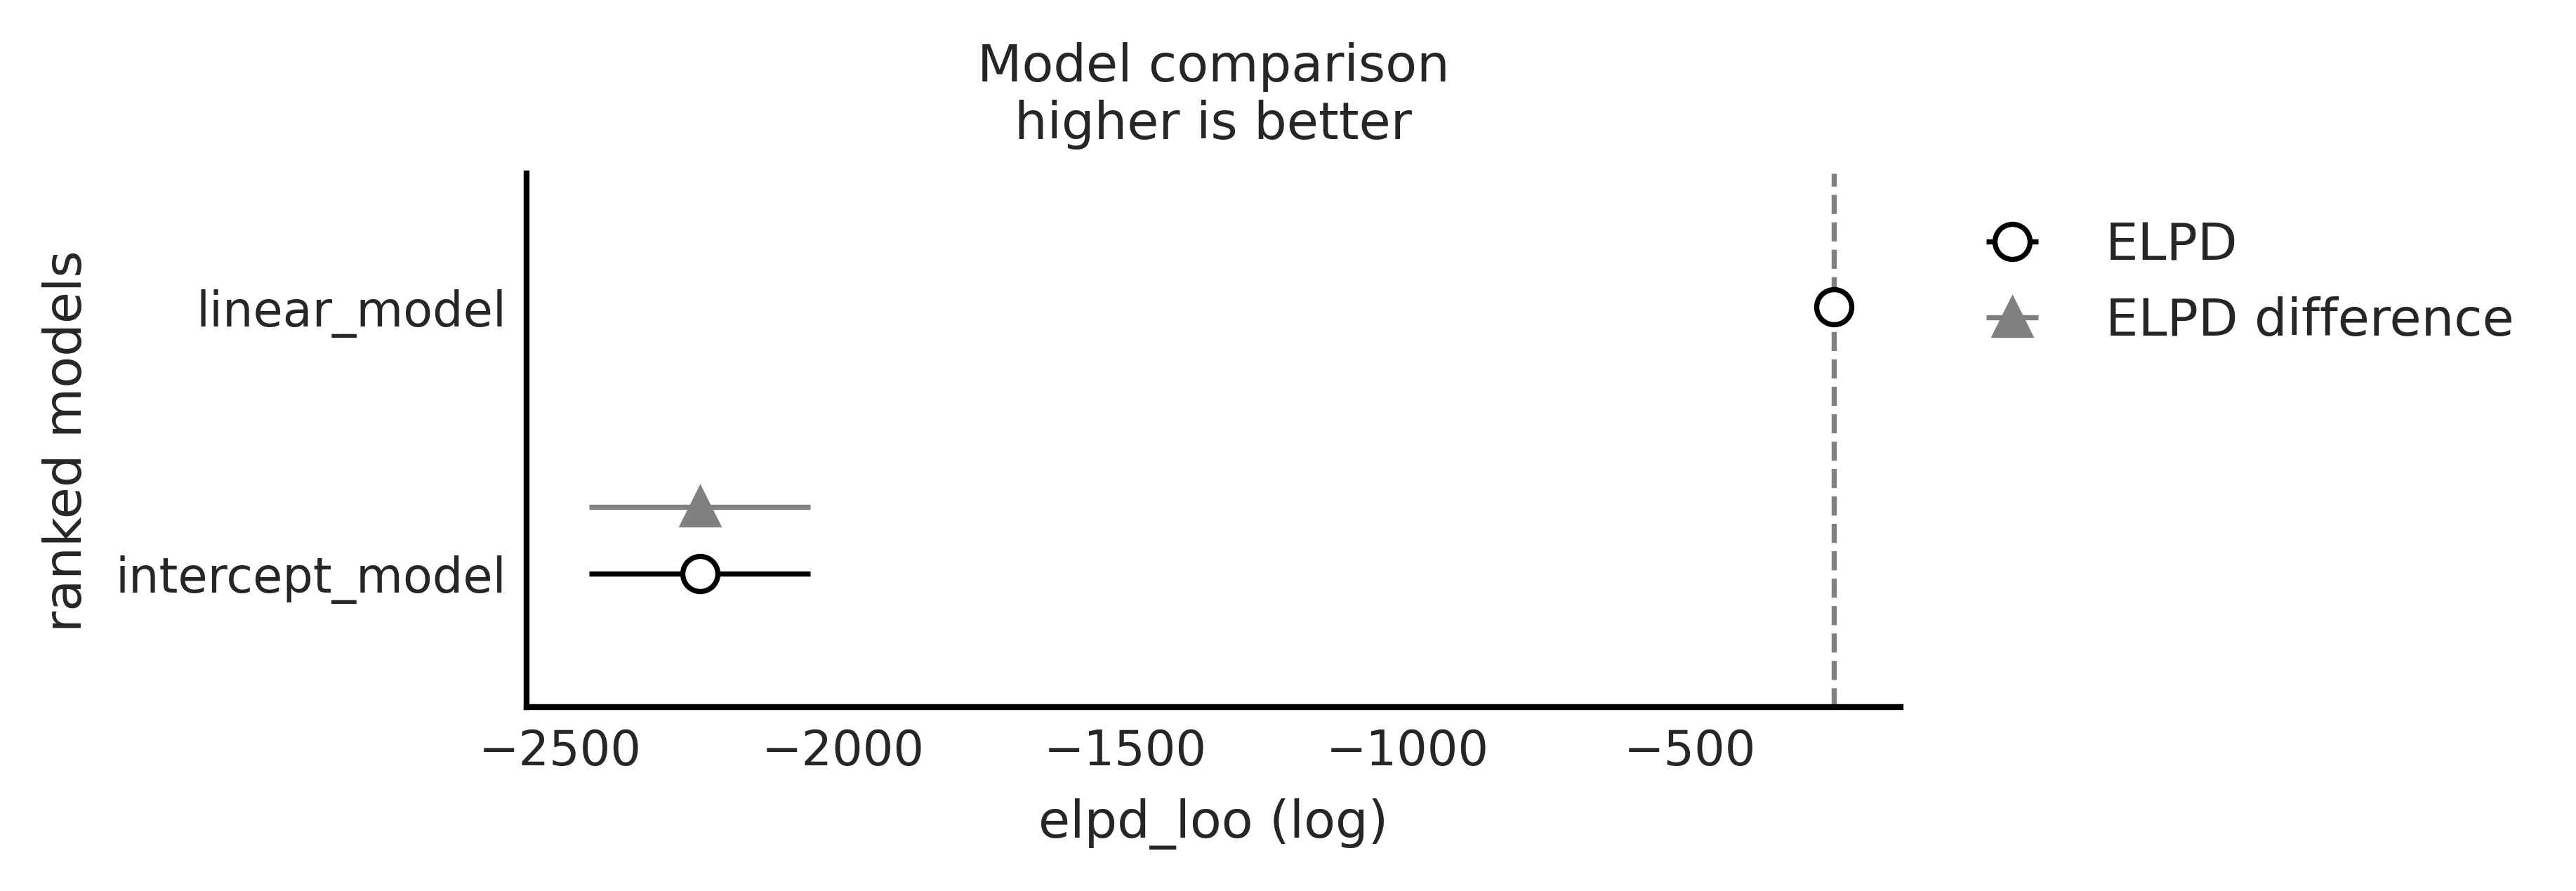

In [24]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy      : 1.25.2
seaborn    : 0.12.2
pandas     : 2.0.3
arviz      : 0.16.0
pymc       : 5.6.1
matplotlib : 3.7.2
scipy      : 1.10.1
statsmodels: 0.14.0

Watermark: 2.4.3

